<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/04.neural_networks/neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels

import tensorflow as tf
import keras
from keras.layers import Dense
from keras.models import Sequential, load_model
from keras.utils import plot_model



!pip install category_encoders
import category_encoders as ce




# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
!pip install git+git://github.com/stared/livelossplot.git
from livelossplot.keras import PlotLossesCallback


# Import the visualization library I prepared for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat


# The following is to be able to mount Google Drive
from google.colab import drive

from os.path import isfile

  Cloning git://github.com/stared/livelossplot.git to /tmp/pip-req-build-a5zv0lio
  Running command git clone -q git://github.com/stared/livelossplot.git /tmp/pip-req-build-a5zv0lio
  Created wheel for livelossplot: filename=livelossplot-0.4.2-cp36-none-any.whl size=12661 sha256=cdeeaf4094a9b9830cee9f7d20472dd4bda4652d1607b2ff6179901788ba1017
  Stored in directory: /tmp/pip-ephem-wheel-cache-ixen0bma/wheels/77/01/ea/cef3581d9c77ece0fd685cc3eb1cd92dc68d8117b361ac65dc
Successfully built livelossplot
--2020-03-17 16:34:56--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4406 (4.3K) [text/plain]
Saving to: ‘visualization.py.2’

visualization.py.2  100

# Use case description

The use case is from [KhConf19].


**Goal** Estimate available bandwidth in a network via **passive measures**.

More precisely:
_Estimate the capacity available to a TCP flow_ (sharing links with other flows) observing
* The time gaps between segments sent $g_{\text{in}}$
* The gaps between acks $g_\text{ack}$



![alt text](https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/04.neural_networks/img/ack.png)
\[Figure from [KhThesis19] \]


The auhtors set up the following testbed:


![alt text](https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/04.neural_networks/img/testbed.png)


Measures are collected in the **Video Receiver**. All the other machines just produce cross-traffic.

Measures are recorded via an Endace Data Acquisition and Generation (DAG) card, which timestamp all packets in an extremely precise way.

![alt text](https://www.endace.com/assets/images/products/DAG%209.5G4F_angled_small.png)

([Producer website](https://www.endace.com/endace-high-speed-packet-capture-solutions/oem/dag/))

**Why**: Knowing the available bandwidth, video streaming clients can properly choose the quality level to request.

# Traces

The description of the dataset can be found in the Appendix of Khangura's [PhD thesis](https://www.repo.uni-hannover.de/bitstream/handle/123456789/9219/Khangura_Sukhpreet_PhD_Thesis.pdf?sequence=3&isAllowed=y).

In [41]:
!wget https://www.ikt.uni-hannover.de/fileadmin/institut/Forschung/BandwidthEstimationTraces/BandwidthEstimationTraces.zip

--2020-03-17 16:26:42--  https://www.ikt.uni-hannover.de/fileadmin/institut/Forschung/BandwidthEstimationTraces/BandwidthEstimationTraces.zip
Resolving www.ikt.uni-hannover.de (www.ikt.uni-hannover.de)... 130.75.2.72
Connecting to www.ikt.uni-hannover.de (www.ikt.uni-hannover.de)|130.75.2.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 941822 (920K) [application/zip]
Saving to: ‘BandwidthEstimationTraces.zip.1’

BandwidthEstimation 100%[===================>] 919.75K   182KB/s    in 5.1s    

2020-03-17 16:26:49 (182 KB/s) - ‘BandwidthEstimationTraces.zip.1’ saved [941822/941822]



In [0]:
! unzip -o -q BandwidthEstimationTraces.zip

In [43]:
!ls BandwidthEstimationTraces

testing  training


Training and test datasets are separated

In [44]:
! ls BandwidthEstimationTraces/training

MultiLinkCapacity100   TightLinkafterBottleneckLink
SingleLinkCapacity100  TightLinkbeforeBottleneckLink
SingleLinkCapacity50


For simplicity, we will just consider the case with a single link between client and server.

In [45]:
! ls BandwidthEstimationTraces/training/SingleLinkCapacity100

25_et_100_C_5_delta  50_et_100_C_5_delta  75_et_100_C_5_delta


There are three sets of traces:
* With cross traffic rate $\lambda$=25 Mbps
* With cross traffic rate $\lambda$=50 Mbps
* With cross traffic rate $\lambda$=75 Mbps

All rates are intended at the Ethernet level

In [46]:
! ls BandwidthEstimationTraces/training/SingleLinkCapacity100/75_et_100_C_5_delta

75_et_100_C_5_delta_100.csv  75_et_100_C_5_delta_55.csv
75_et_100_C_5_delta_10.csv   75_et_100_C_5_delta_56.csv
75_et_100_C_5_delta_11.csv   75_et_100_C_5_delta_57.csv
75_et_100_C_5_delta_12.csv   75_et_100_C_5_delta_58.csv
75_et_100_C_5_delta_13.csv   75_et_100_C_5_delta_59.csv
75_et_100_C_5_delta_14.csv   75_et_100_C_5_delta_5.csv
75_et_100_C_5_delta_15.csv   75_et_100_C_5_delta_60.csv
75_et_100_C_5_delta_16.csv   75_et_100_C_5_delta_61.csv
75_et_100_C_5_delta_17.csv   75_et_100_C_5_delta_62.csv
75_et_100_C_5_delta_18.csv   75_et_100_C_5_delta_63.csv
75_et_100_C_5_delta_19.csv   75_et_100_C_5_delta_64.csv
75_et_100_C_5_delta_1.csv    75_et_100_C_5_delta_65.csv
75_et_100_C_5_delta_20.csv   75_et_100_C_5_delta_66.csv
75_et_100_C_5_delta_21.csv   75_et_100_C_5_delta_67.csv
75_et_100_C_5_delta_22.csv   75_et_100_C_5_delta_68.csv
75_et_100_C_5_delta_23.csv   75_et_100_C_5_delta_69.csv
75_et_100_C_5_delta_24.csv   75_et_100_C_5_delta_6.csv
75_et_100_C_5_delta_25.csv   75_et_100_C_5_delta_7

Every experiment is repeated 100 times.

Let's check the trace of one experiment

In [47]:
filename = "BandwidthEstimationTraces/training/SingleLinkCapacity100/75_et_100_C_5_delta/75_et_100_C_5_delta_33.csv"
df = pd.read_csv(filename)
df

,100,25
0,1.00060,4.9907
1,0.99982,9.9443
2,1.00340,14.9910
3,1.01250,19.9870
4,1.09670,25.0280
5,1.10830,29.9820
6,1.27700,35.3180
7,1.27810,39.9750
8,1.24280,44.5390
9,1.42630,50.0520


The header is not a sample. It just tells us the scenario, i.e. total channel capacity (Mbps) and available bandwith (Mbps).

The columns are:
* $g_\text{in} / g_\text{ack}$
* Some sort of time stamp that we will ignore (not well described in the dataset)

Let's rename the columns to avoid ambiguity

In [48]:
df.columns=['gap_ratio', 'timestamp']
df.head()

,gap_ratio,timestamp
0,1.00060,4.9907
1,0.99982,9.9443
2,1.00340,14.9910
3,1.01250,19.9870
4,1.09670,25.0280


# Feature engineering

Each experiment will be a sample.

The features of a sample are the elements of the histogram of the first column

(array([2.46797799, 1.23398899, 0.6169945 , 1.23398899, 1.23398899,
        1.23398899, 1.23398899, 0.6169945 , 0.6169945 , 1.85098349]),
 array([0.99982 , 1.080858, 1.161896, 1.242934, 1.323972, 1.40501 ,
        1.486048, 1.567086, 1.648124, 1.729162, 1.8102  ]),
 <a list of 10 Patch objects>)

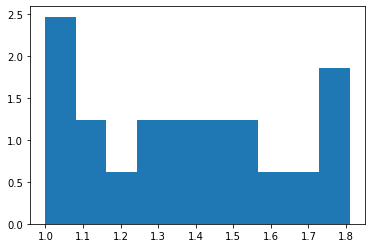

In [49]:
plt.hist(df['gap_ratio'], density=True)

# density:  True garantees that the area is 1 (such that hist approximates a 
#                 probability densitplt.hist(x)y function)

However, the sequence of bins is chosen automatically by `matplotlib` and may change from an experiment to another.

We need instead to describe all the experiments with a uniform set of features => The sequence of bins must be the same for all the experiments.

To do so:
* Open all files
* Take the min and max gap from all the experiments
* Divide the [min,max] interval uniformly

In [0]:
def get_all_csv_files(folder):
  """
  Credits to https://perials.com/getting-csv-files-directory-subdirectories-using-python/

  Returns all the csv files within the folder, and all subfolders
  """
  import os
  from glob import glob
  PATH = "/home/someuser/projects/someproject"
  EXT = "*.csv"
  all_csv_files = [file
                  for path, subdir, files in os.walk(folder)
                  for file in glob(os.path.join(path, "*.csv"))]
  return all_csv_files

To avoid data leaks, we compute the max and the min on the training set only.

In [51]:
train_files = get_all_csv_files('BandwidthEstimationTraces/training')
print('Found ', len(train_files), ' training files' )

Found  1100  training files


Find the min and max

In [52]:
min_gap = float('inf')
max_gap = 0

for filename in train_files:
      df = pd.read_csv(filename)
      df.columns=['gap_ratio', 'timestamp']
      trace_min = min( df['gap_ratio'] )
      trace_max = max( df['gap_ratio'] )
      min_gap = min ( [ min_gap, trace_min ] )
      max_gap = max ( [ max_gap, trace_max ] )

print('min_gap:', min_gap, ' max_gap:',max_gap)

min_gap: 0.95975  max_gap: 2.318


Let's create the bins that we will use for all experiments

In [53]:
N = 8 # num of bins

bin_size = (max_gap-min_gap)/N 
bins = [min_gap + i * bin_size for i in range(0, N+1)]
bins

[0.95975,
 1.1295312499999999,
 1.2993125,
 1.4690937499999999,
 1.638875,
 1.8086562499999999,
 1.9784375,
 2.14821875,
 2.318]

Just as a visual check, let's plot again the previous histogram with these new bins

[1.76697957 0.88348978 1.17798638 0.88348978 0.88348978 0.29449659
 0.         0.        ]


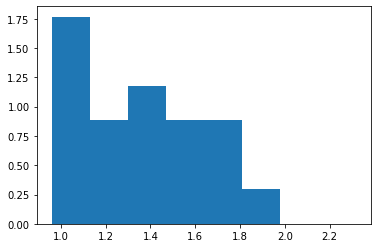

In [54]:
filename = "BandwidthEstimationTraces/training/SingleLinkCapacity100/75_et_100_C_5_delta/75_et_100_C_5_delta_33.csv"
df = pd.read_csv(filename)
df.columns=['gap_ratio', 'timestamp']
hist_values, bins, bars = plt.hist( df['gap_ratio'], density=True, bins=bins)
print(hist_values )

Let's obtain the histogram for all the experiments. For each experiment, we construct a feature vector:

  `[bin1_freq, bin2_freq, ...., binN_freq]`

and a label `avail_bandwidth`.

We write these operations in a function `construct_dataset` that we will then use for the training and the test dataset

In [0]:
def process_file(filename, bins):
      """
      For the connection described in filename, it
      returns a feature vector and the available bandwidth
      """
      df = pd.read_csv(filename)

      # Observe that for each experiment, the available bandwidth corresponds 
      # to the name of the second column
      avail_band = df.columns[1]


      df.columns=['gap_ratio', 'timestamp']

      histogram_values, bins, bars = plt.hist( df['gap_ratio'], density=True, 
                                              bins=bins)

      return histogram_values, avail_band



def construct_dataset(files, bins):
  """
  Build an X,y from the files
  """

  X = np.empty((0,N), int)
  label = []

  for filename in files:
      histogram_values, avail_band = process_file(filename, bins)

      X = np.vstack(( X, histogram_values) )
      label.append(avail_band)

  return X,label

Found  1000  test files


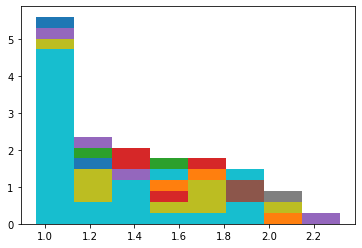

In [56]:
X_train, label_train = construct_dataset(train_files, bins)

test_files = get_all_csv_files('BandwidthEstimationTraces/testing')
print ('Found ', len(test_files), ' test files'  )

X_test, label_test = construct_dataset(test_files, bins)

In [57]:
print('X_train\n', X_train[0:6, :] )
print('\n\nlabel_train\n',label_train )

X_train
 [[4.41744892 0.88348978 0.58899319 0.         0.         0.
  0.         0.        ]
 [4.12295233 1.17798638 0.58899319 0.         0.         0.
  0.         0.        ]
 [4.41744892 0.88348978 0.58899319 0.         0.         0.
  0.         0.        ]
 [4.41744892 1.17798638 0.29449659 0.         0.         0.
  0.         0.        ]
 [4.41744892 0.88348978 0.58899319 0.         0.         0.
  0.         0.        ]
 [4.71194552 1.17798638 0.         0.         0.         0.
  0.         0.        ]]


label_train
 ['50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '5

With NN is important to **scale** the dataset

In [58]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('X_train_scaled\n', X_train_scaled[0:6, :] )

X_train_scaled
 [[0.8        0.375      0.28571429 0.         0.         0.
  0.         0.        ]
 [0.73333333 0.5        0.28571429 0.         0.         0.
  0.         0.        ]
 [0.8        0.375      0.28571429 0.         0.         0.
  0.         0.        ]
 [0.8        0.5        0.14285714 0.         0.         0.
  0.         0.        ]
 [0.8        0.375      0.28571429 0.         0.         0.
  0.         0.        ]
 [0.86666667 0.5        0.         0.         0.         0.
  0.         0.        ]]


**One-hot encode** the target

In [59]:
# OneHotEncoder works best with dataframes. Let's convert our y lists to 
# dataframes
label_train_df = pd.DataFrame({'label':label_train})
label_test_df = pd.DataFrame({'label':label_test})

label_train_df

,label
0,50
1,50
2,50
3,50
4,50
...,...
1095,37.5
1096,37.5
1097,37.5
1098,37.5


In [61]:
encoder = ce.OneHotEncoder(cols=['label'], use_cat_names='True')
encoder.fit(label_train_df)
y_train = encoder.transform(label_train_df)
y_test  = encoder.transform(label_test_df)

print('y_train', y_train)

num_of_classes = y_train.shape[1]
class_names = y_train.columns
print('There are ', num_of_classes, ' classes:', class_names)

y_train       label_50  label_25  label_75  label_12.5  label_37.5
0            1         0         0           0           0
1            1         0         0           0           0
2            1         0         0           0           0
3            1         0         0           0           0
4            1         0         0           0           0
...        ...       ...       ...         ...         ...
1095         0         0         0           0           1
1096         0         0         0           0           1
1097         0         0         0           0           1
1098         0         0         0           0           1
1099         0         0         0           0           1

[1100 rows x 5 columns]
There are  5  classes: Index(['label_50', 'label_25', 'label_75', 'label_12.5', 'label_37.5'], dtype='object')


# Build a NN model

To train faster, change the runtime to GPU.

Now, let's build a NN architecture. The size of each sample is:

In [62]:
sample_size = X_train_scaled.shape[1]
print('The sample size is ', sample_size, 
      ', which should correspond to the number of bins ', N)

The sample size is  8 , which should correspond to the number of bins  8


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 25        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


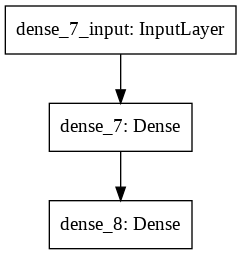

In [63]:
model = Sequential([
  Dense(4, input_dim=sample_size, activation='relu' ),
  Dense(num_of_classes, activation="softmax")
])

# The first layer has 4 neurons and take 8 input values.
# In the first layer, you always need to specify the input_dim
#
# Note that each layer adds implicitly a bias term (we do not need to care about 
# it)
#
# The last layer is a softmax, since we are doing classification


model.summary()
plot_model(model)

`None` means that the batch size can be any value.

Compile the model, i.e., decide the loss function to minimize, the optimization function and the metrics to show

In [0]:
model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.SGD(lr=0.01) ,
              metrics=['accuracy'])

See Ch.10 of [Ge19] to know more about these hyper-parameters.

Loss function:
* `categorical_crossentropy` is the cross-entropy as we defined in the slides
* In binary classification then use `sigmoid` activation function in the output layer instead of the `softmax` and `binary_crossentropy` loss.

Optimizer:
* We are using Stochastic Gradient Descent with learning rate $\eta=0.01$

Metrics:
* We are asking Keras to show at each epoch the accuracy. Note that the accuracy value is ignored during training. This metric is just visualized

# Training

To train faster, change the runtime to GPU.

### Simple training and testing

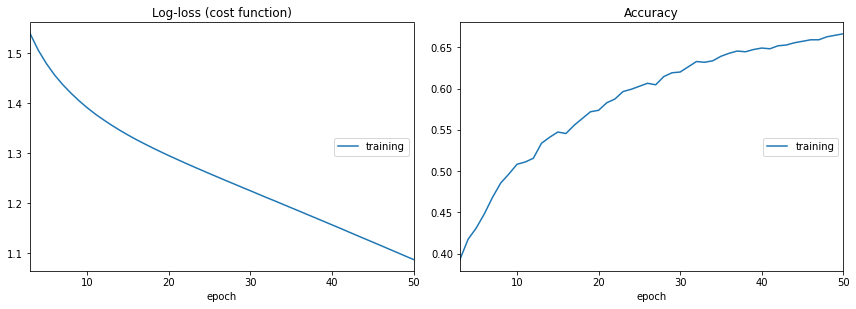

Log-loss (cost function):
training   (min:    1.088, max:    1.637, cur:    1.088)

Accuracy:
training   (min:    0.285, max:    0.666, cur:    0.666)


In [65]:
epochs = 50


plot_losses = PlotLossesCallback()  # Just to plot the evolution of 
                                    # loss during training

model.fit(X_train_scaled, y_train, epochs=epochs, 
                    callbacks = [plot_losses] )

Just for the sake of time, we have interrupted training too soon, while the loss was continuing to decrease. 

Let's check the performance on the test set

In [66]:
y_proba = model.predict(X_test_scaled)
print( 'y_proba\n', y_proba)

pred_label = model.predict_classes(X_test_scaled)
print( 'pred_label\n', pred_label )

y_proba
 [[0.5678341  0.16782169 0.10524691 0.04860792 0.11048944]
 [0.6554108  0.10913835 0.09552377 0.03607614 0.10385095]
 [0.7143239  0.07559988 0.08610435 0.02773938 0.09623259]
 ...
 [0.3692203  0.33781582 0.10987204 0.07542448 0.1076674 ]
 [0.29440692 0.4161097  0.10511807 0.08405109 0.10031416]
 [0.5193619  0.20459048 0.10857752 0.05546319 0.11200694]]
pred_label
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 

The best metric is the confusion matrix

In [67]:
y_test.values

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [68]:
true_label = np.argmax(y_test.values, axis=1)
true_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Normalized confusion matrix
[[0.64666667 0.35333333 0.        ]
 [0.09333333 0.90666667 0.        ]
 [1.         0.         0.        ]]


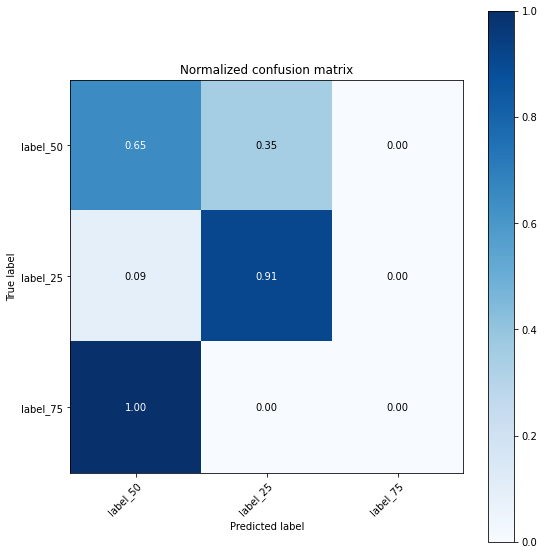

In [69]:
plot_conf_mat(true_label, pred_label, np.array(class_names) )

Note that we have 5 classes in total, but only 3 appear in the confusion matrix. This is because only 3 of these labels appear in the test set and among the predicted labels. To verify this, run:

In [75]:
unique_labels(true_label, pred_label)

array([0, 1, 2])

The performance is very poor. We need to improve our model.

### Automate build

If you run `model.fit` again, you will not start from scratch, but you will start from current weights.

Since we want to compare different training strategies, we will build a model from scratch every time.

We write a function to automate the building process

In [0]:
def build_model():
  # Reproducibility: to ensure every time we generate a model, its weights are 
  #     always initialized in the same way
  # To know more: 
  #       https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
  np.random.seed(6)
  tf.set_random_seed(4)


  model = Sequential([
   Dense(4, input_dim=sample_size, activation='relu'),
   Dense(num_of_classes, activation='softmax')
  ])

  model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.SGD(lr=0.01),
                metrics=['accuracy']
                )

  return model

### Save and load models

Training a neural network may take long time and you don't want to do it every time. Once you've trained a model, it is better to save it, so that you can use it immediately for prediction next times.

Unfortunately, the storage on Google is reset every time. You need to store all persistent data in you Google Drive.

In [77]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it
my_path = drive_path + \
  'tsp/teaching/data-science-for-networks/img-from-code/04.neural-networks/'

Mounted at /content/gdrive


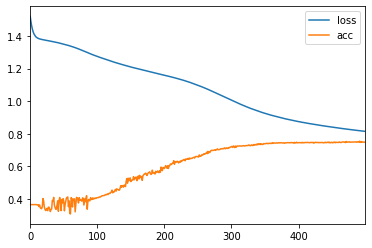

In [78]:
epochs=500

plot_losses = PlotLossesCallback()  # Just to plot the evolution of 
                                    # loss during training

nn_file = my_path + 'nn1.h5'


if not isfile(nn_file):
  ###### Build and train the model

  model = build_model()
  history = model.fit(X_train_scaled, y_train, epochs=epochs, 
                    callbacks = [plot_losses] )
  
  # Save the trained model
  model.save( nn_file )

  # Save the history as well
  pd.DataFrame.from_dict(history.history).to_csv(nn_file+'.hist.csv', 
                                                 index=False)

else:
  ##### Load the model already trained
  model = load_model( nn_file )

  # Load the history as well
  hist_df = pd.read_csv(nn_file+'.hist.csv')

  # Plot the history
  hist_df.plot()

We can automate this code

In [0]:
def train_or_load_model(nn_file, X_tr, y_tr):
  plot_losses = PlotLossesCallback()  # Just to plot the evolution of 
                                    # loss during training

  if not isfile(nn_file):
    model = build_model()
    history = model.fit(X_tr, y_tr, epochs=epochs, 
                      callbacks = [plot_losses] )
    model.save( nn_file )

    # From https://stackoverflow.com/a/59854096/2110769
    pd.DataFrame.from_dict(history.history).to_csv(nn_file+'.hist.csv',
                                                   index=False)
    return model
    
  else:
    model = load_model( nn_file )
    hist_df = pd.read_csv(nn_file+'.hist.csv')
    hist_df.plot()
    return model

Let's run this function

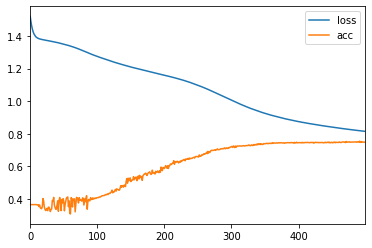

In [80]:
nn_file = my_path + 'nn1.h5'

model = train_or_load_model(nn_file, X_train_scaled, y_train)

Normalized confusion matrix
[[0.84666667 0.15333333 0.        ]
 [0.13333333 0.86666667 0.        ]
 [1.         0.         0.        ]]


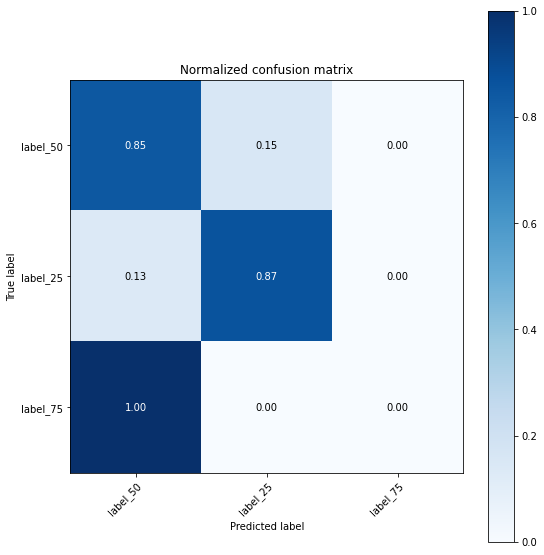

In [82]:
pred_label = model.predict_classes(X_test_scaled)
plot_conf_mat(true_label, pred_label, np.array(class_names) )

We could have run more epochs, as the loss was still decreasing, but can we improve the model without running to infinity?

# Importance of randomness

Hypothesis on a possible problem:
* Stochastic gradient descent works well when the gradient of the loss function in each sample 
$$
  \nabla J (\boldsymbol{\theta},x^{(i)}, y^{(i)})
$$
is an unbiased estimate of the true loss function
$$
  \nabla J (\boldsymbol{\theta},\mathbf{X}, \mathbf{y}) =
  \frac{1}{m} \sum_{i=1}^m \nabla J (\boldsymbol{\theta},x^{(i)}, y^{(i)})
$$
Therefore, the sequence of $x^{(i)},y^{(i)}$ should "look" randomly chosen. In our case, instead, our training samples have a specific order.

In [83]:
y_train

,label_50,label_25,label_75,label_12.5,label_37.5
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
1095,0,0,0,0,1
1096,0,0,0,0,1
1097,0,0,0,0,1
1098,0,0,0,0,1


How can we solve this?

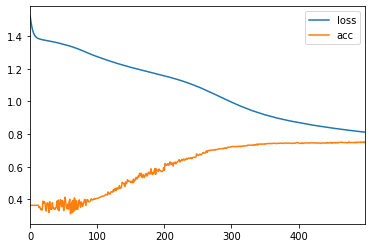

In [84]:
X_train_scaled_sh, y_train_sh = shuffle(X_train_scaled, y_train, random_state=3)

nn_file = my_path + 'nn2.h5'

model = train_or_load_model(nn_file, X_train_scaled_sh, y_train_sh)

Way better now!

Let's test the performance on the test set

Normalized confusion matrix
[[0.84666667 0.15333333 0.        ]
 [0.13333333 0.86666667 0.        ]
 [1.         0.         0.        ]]


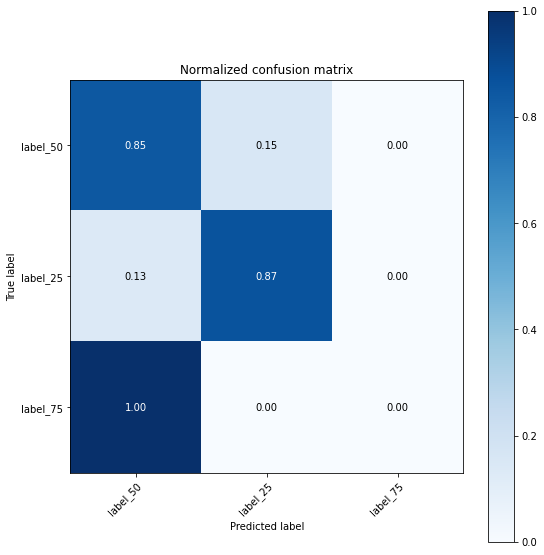

In [85]:
pred_label = model.predict_classes(X_test_scaled)

plot_conf_mat(true_label,pred_label, np.array(class_names) )

# Evaluate overfitting

We can still improve

Hypothesis:
* The NN may be overfitting

How do we verify this?

**Always** better to divide the training set in training and validation:
* Loss minimization is performed only on the training set
* we also plot the evolution of the loss and the accuracy on the validation
    * It does not impact the training
    * It just allows us to check:
        * If training error decreases but validation error increases => OVERFITTING


Let's modify our `train_or_load_model` function accordingly

In [0]:
def train_or_load_model(nn_file, X_tr, y_tr):
  plot_losses = PlotLossesCallback()  # Just to plot the evolution of 
                                    # loss during training

  if not isfile(nn_file):
    model = build_model()

    ##### MODIFIED PART{
    X_train_part, X_valid_part, y_train_part,  y_valid_part = \
          train_test_split(X_tr, y_tr, test_size=0.2, random_state=3)

    history = model.fit(X_tr, y_tr, epochs=epochs, 
                        callbacks = [plot_losses],
                        validation_data = (X_valid_part, y_valid_part)
                        )
    ##### MODIFIED PART}
    
    model.save( nn_file )

    # From https://stackoverflow.com/a/59854096/2110769
    pd.DataFrame.from_dict(history.history).to_csv(nn_file+'.hist.csv',
                                                   index=False)
    return model
    
  else:
    model = load_model( nn_file )
    hist_df = pd.read_csv(nn_file+'.hist.csv')
    hist_df.plot()

    return model

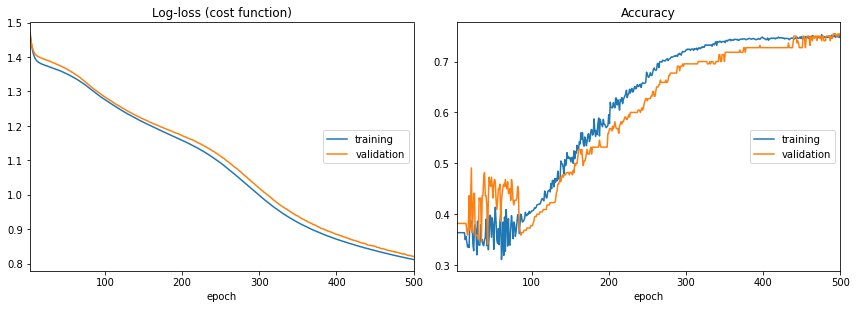

Log-loss (cost function):
training   (min:    0.812, max:    1.522, cur:    0.812)
validation (min:    0.821, max:    1.510, cur:    0.821)

Accuracy:
training   (min:    0.311, max:    0.753, cur:    0.751)
validation (min:    0.341, max:    0.755, cur:    0.755)


In [96]:
nn_file = my_path + 'nn3.h5'
model = train_or_load_model(nn_file, X_train_scaled_sh, y_train_sh)

# Limitation of the work

* Only a finite set of available bandwidth values are used (25, 50, 75 Mbps). In reality, any value can occur => Need to extend the test and validation test with random bandwidth values.

# References

* [Ge19] Geron, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2019, O'Reilly
* [KhConf19] Khangura, S. K. (2019). Neural Network-based Available Bandwidth Estimation from TCP Sender-side Measurements. In IEEE/IFIP PEMWN.
* [KhThesis19] Khangura, S. K. (2019). Machine Learning-based Available Bandwidth Estimation. Leibniz University.